# CNN 

The model maps five physical input parameters to a 100×100 meshed field representing the solidification morphology. We use a convolutional neural network due to the spatial structure of the output, which resembles an image. The network begins with three fully connected layers with ReLU activations to model nonlinear relationships between the input parameters, producing a 512-dimensional latent representation. This latent vector is reshaped into an 8×8×8 tensor, which is then passed through four ConvTranspose2d layers with ReLU activations to upsample the data to a higher spatial resolution. A final Sigmoid activation ensures the output remains in [0,1][0,1], consistent with the phase-field variable representing solid (1) and liquid (0) regions.

In [ ]:
# Cell 0
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Cell 1
# Load the training and testing sets
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

# Remove index 228 (outlier)
X_train = np.delete(X_train, 228, axis=0)
Y_train = np.delete(Y_train, 228, axis=0)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(249, 5) (249, 100, 100)
(63, 5) (63, 100, 100)


In [ ]:
# Cell 2
class DendriteDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = DendriteDataset(X_train, Y_train)
test_dataset = DendriteDataset(X_test, Y_test)


In [ ]:
# Cell 3
# Network architecture
class DendriteCNN(nn.Module):
    def __init__(self):
        super(DendriteCNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),  # 32x32 → 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),   # 64x64 → 128x128
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 8, 8, 8)  # Reshape to (batch, channels, height, width)
        x = x.permute(0, 2, 3, 1)  # Correct for ConvTranspose2d
        x = x.permute(0, 3, 1, 2)  # Make it (batch, channels, height, width)
        x = self.decoder(x)
        x = x[:, :, :100, :100]  # Crop to 100x100
        return x


In [ ]:
# Cell 4
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = DendriteCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 500

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)  # (B, 1, 100, 100)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.5f}")


Epoch [1/500], Loss: 0.22537
Epoch [2/500], Loss: 0.20622
Epoch [3/500], Loss: 0.17482
Epoch [4/500], Loss: 0.14120
Epoch [5/500], Loss: 0.13439
Epoch [6/500], Loss: 0.12926
Epoch [7/500], Loss: 0.12514
Epoch [8/500], Loss: 0.12130
Epoch [9/500], Loss: 0.11705
Epoch [10/500], Loss: 0.11266
Epoch [11/500], Loss: 0.10791
Epoch [12/500], Loss: 0.10370
Epoch [13/500], Loss: 0.09999
Epoch [14/500], Loss: 0.09687
Epoch [15/500], Loss: 0.09428
Epoch [16/500], Loss: 0.09161
Epoch [17/500], Loss: 0.08983
Epoch [18/500], Loss: 0.08862
Epoch [19/500], Loss: 0.08850
Epoch [20/500], Loss: 0.08764
Epoch [21/500], Loss: 0.08672
Epoch [22/500], Loss: 0.08620
Epoch [23/500], Loss: 0.08590
Epoch [24/500], Loss: 0.08539
Epoch [25/500], Loss: 0.08573
Epoch [26/500], Loss: 0.08494
Epoch [27/500], Loss: 0.08419
Epoch [28/500], Loss: 0.08460
Epoch [29/500], Loss: 0.08568
Epoch [30/500], Loss: 0.08330
Epoch [31/500], Loss: 0.08334
Epoch [32/500], Loss: 0.08337
Epoch [33/500], Loss: 0.08240
Epoch [34/500], Los

In [ ]:
# Cell 5
def evaluate_mse(model, loader, dataset_name="Dataset"):
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)  # sum over batch

    mse = total_loss / len(loader.dataset)
    print(f"{dataset_name} MSE: {mse:.6f}")
    return mse

# Evaluate on train and test sets
train_mse = evaluate_mse(model, train_loader, "Training")
test_mse = evaluate_mse(model, test_loader, "Testing")


Training MSE: 0.007404
Testing MSE: 0.007887


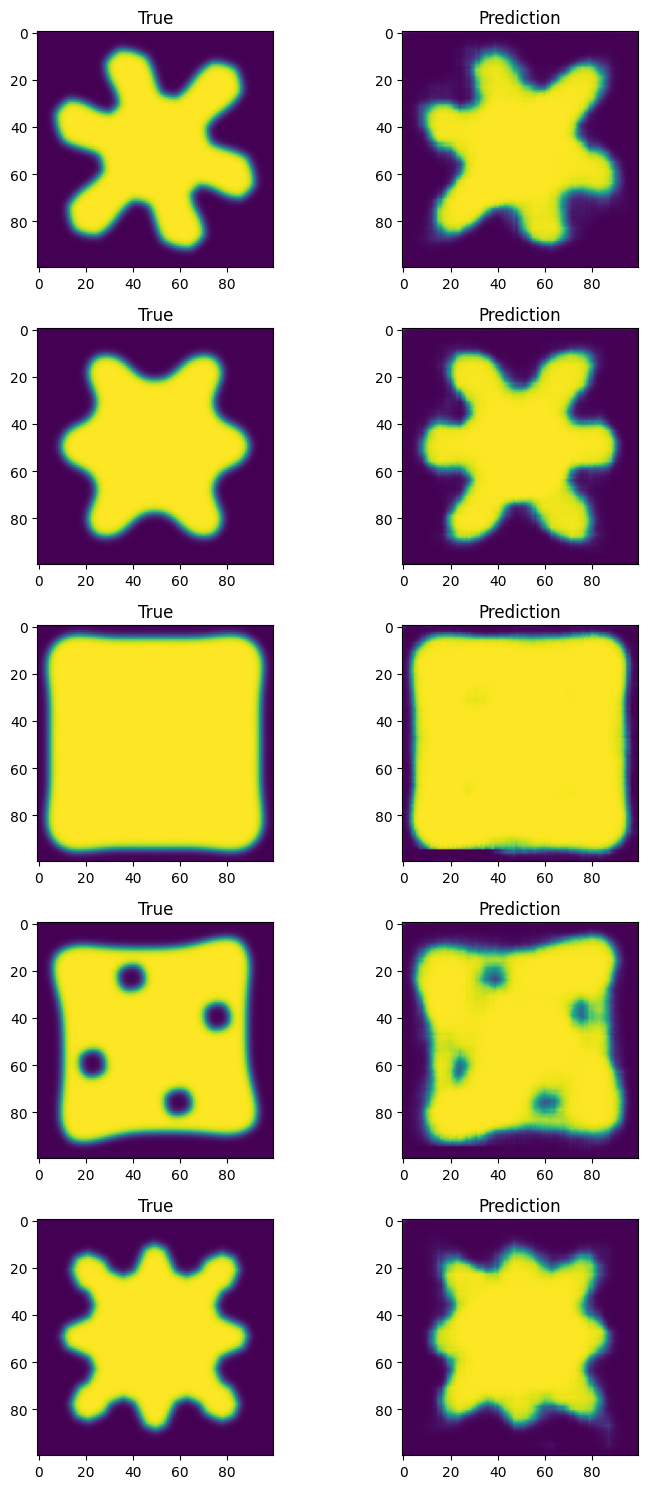

In [13]:
# Cell 6
model.eval()

def plot_predictions(model, dataset, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, n_samples * 3))
    for i in range(n_samples):
        x, y = dataset[i]
        x = x.unsqueeze(0).to(device)
        pred = model(x).detach().cpu().squeeze(0).squeeze(0)
        
        axes[i,0].imshow(y.numpy(), cmap='viridis', vmin=0, vmax=1)
        axes[i,0].set_title('True')
        axes[i,1].imshow(pred.numpy(), cmap='viridis', vmin=0, vmax=1)
        axes[i,1].set_title('Prediction')
    
    plt.tight_layout()
    plt.show()

plot_predictions(model, test_dataset)
